In [1]:
import numpy as np
import pandas as pd
weight = 0.7
bias = 0.3
start = 0
stop = 1
step = 0.02
x = np.arange(start, stop, step)
y = weight * x + bias
data = {'x': x,
        'y': y
}
frame = pd.DataFrame(data)
frame.head()

,x,y
0,0.00,0.300
1,0.02,0.314
2,0.04,0.328
3,0.06,0.342
4,0.08,0.356


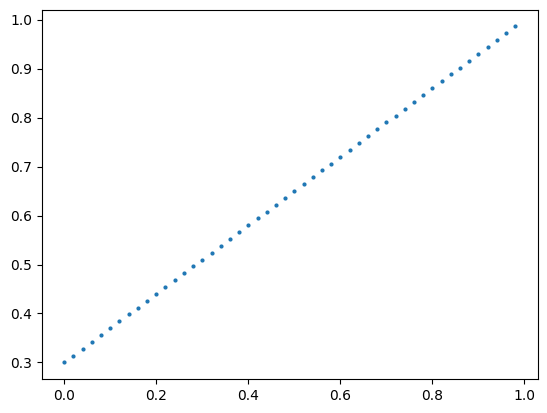

In [2]:
import matplotlib.pyplot as plt
plt.scatter(x, y, 4)

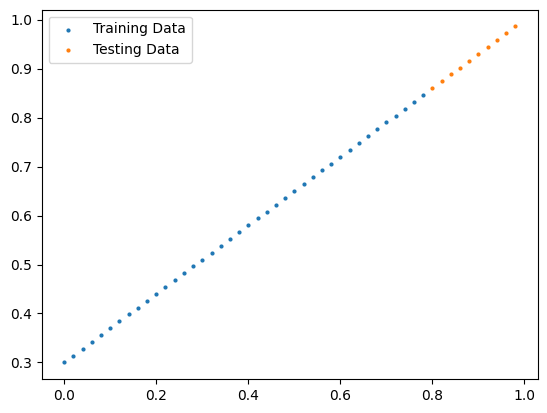

In [3]:
import torch
trainingSplit = int(0.8 * len(x))
XTrain = x[:trainingSplit]
yTrain = y[:trainingSplit]
XTest = x[trainingSplit:]
yTest = y[trainingSplit:]
data = [XTrain, yTrain, XTest, yTest]
for i, arr in enumerate(data):
    # We need to turn the data into tensors, so we can use PyTorch functions on the data.
    data[i] = torch.from_numpy(arr).to(torch.float).unsqueeze(1)
XTrain, yTrain, XTest, yTest = data
plt.scatter(XTrain, yTrain, 4, label='Training Data')
plt.scatter(XTest, yTest, 4, label='Testing Data')
plt.legend()

In PyTorch's torch.nn there is a class called Linear that provides a weight and a bias. The formula for a linear function is y = xA + b, where A is the weight and b is the bias. This will be the forward method of the Model class.

In [4]:
from torch import nn
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(1))
        self.bias = nn.Parameter(torch.rand(1))
    def forward(self, x_in):
        return self.weight * x_in + self.bias
model = Model()
weight, bias, model.state_dict()

(0.7,
 0.3,
 OrderedDict([('weight', tensor([0.6889])), ('bias', tensor([0.4026]))]))

In [5]:
initialWeight = model.state_dict()['weight']
XTest, initialWeight, XTest.shape, initialWeight.shape

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([0.6889]),
 torch.Size([10, 1]),
 torch.Size([1]))

We can't do matrix multiplication unless the second dimension of the first matrix is the same as the first dimension of the second matrix. The first matrix is the tensor of x-values and the second matrix is the weight. Thus, we needed to make the shape of the tensor end in a 1. PyTorch has a function called un-squeeze that adds a dimension of size 1 at the specified position. Instead of containing numbers, the tensor now contains tensors that each have 1 number.

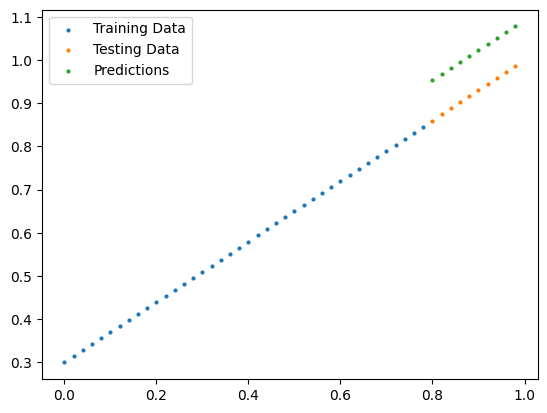

In [6]:
def predict_and_plot(model_in):
    # turns off requires grad which matplotlib doesn't like
    with torch.inference_mode():
        y_predictions = model_in(XTest)
    plt.scatter(XTrain, yTrain, 4, label='Training Data')
    plt.scatter(XTest, yTest, 4, label='Testing Data')
    plt.scatter(XTest, y_predictions, 4, label='Predictions')
    plt.legend()
predict_and_plot(model)

The loss function measures the mean absolute error between the model's predictions and the actual data. Mean absolute error is the average distance between the prediction and the true value. It is calculated as the sum of all the absolute values of each prediction minus each true value divided by the number of predictions.
The optimizer is what changes the parameters of a function. This optimizer uses stochastic gradient descent (SGD). SGD has a parameter lr which is the learning rate. A learning rate of 0.01 works best on this data. A learning rate of 0.1 does not allow the parameters to get close enough to the actual values.

learningRate=0.001
Target values: weight=0.7, bias=0.3
Initial parameters: OrderedDict({'weight': tensor([0.3478]), 'bias': tensor([0.4110])})


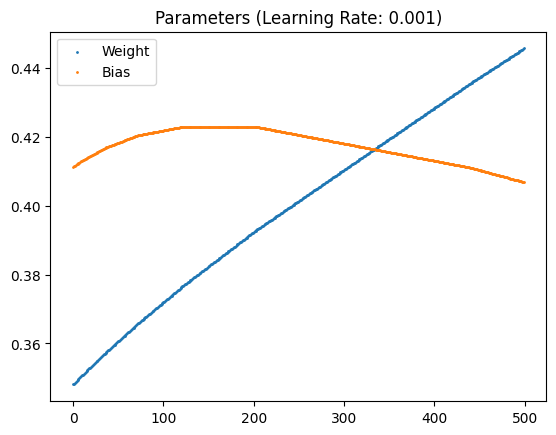

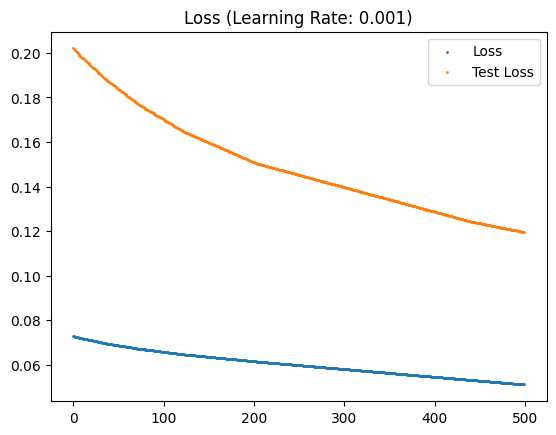

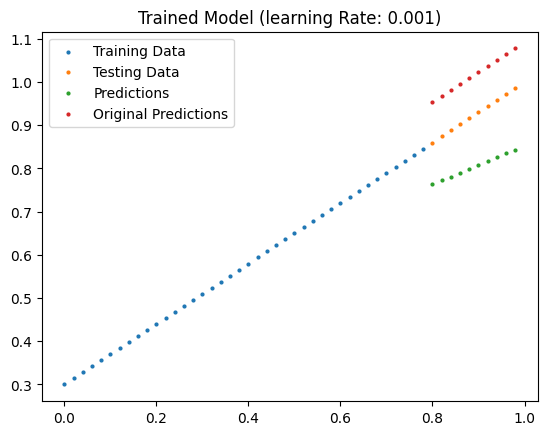

learningRate=0.01
Target values: weight=0.7, bias=0.3
Initial parameters: OrderedDict({'weight': tensor([0.7021]), 'bias': tensor([0.7111])})


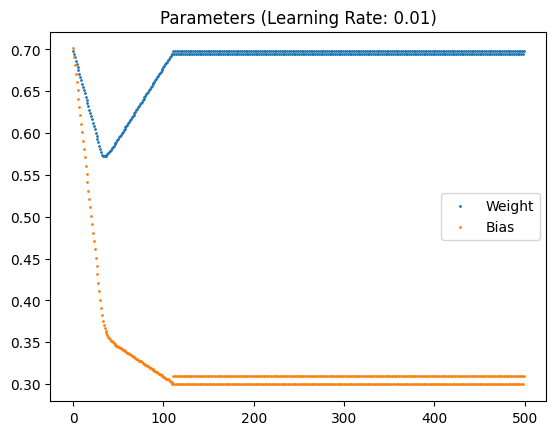

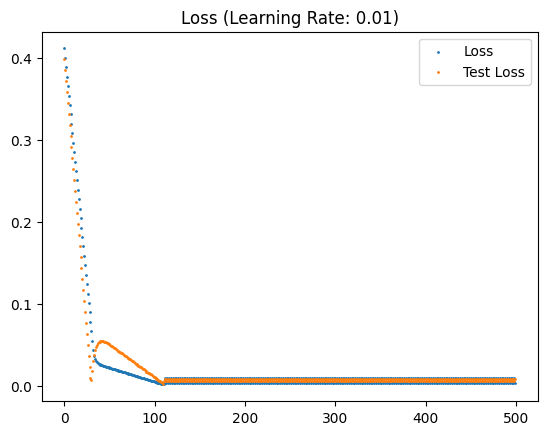

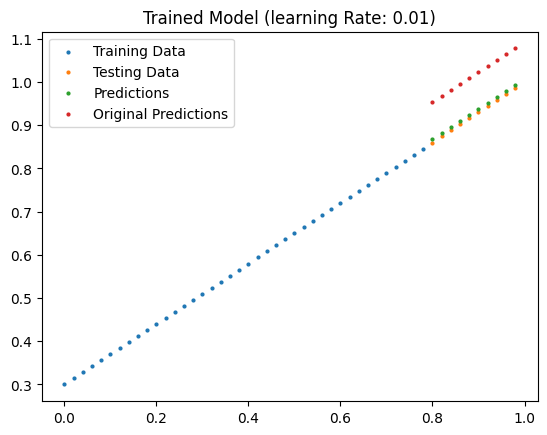

learningRate=0.1
Target values: weight=0.7, bias=0.3
Initial parameters: OrderedDict({'weight': tensor([0.2606]), 'bias': tensor([0.2807])})


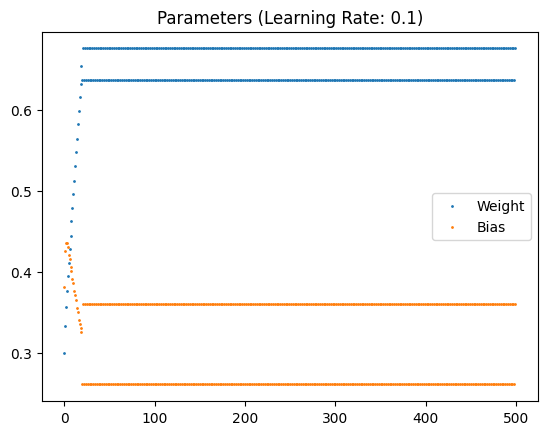

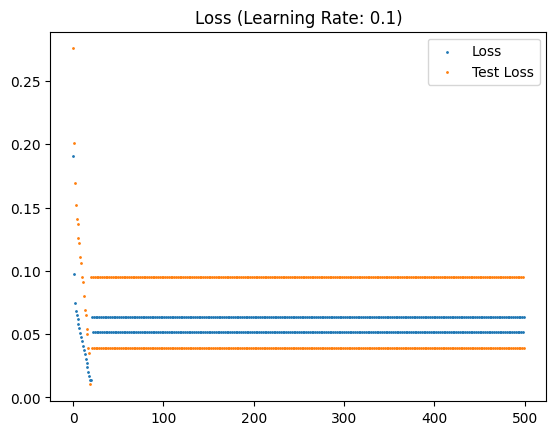

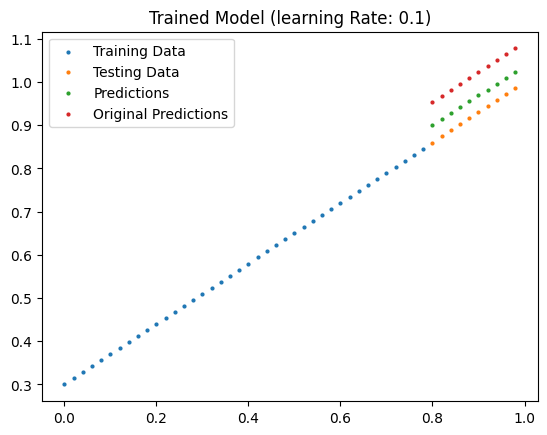

In [7]:
epochs = 500
def train(model_in, learning_rate):
    loss_fun = nn.L1Loss()
    optimizer = torch.optim.SGD(model_in.parameters(), lr=learning_rate)
    loss_array = np.array([])
    test_loss_array = np.array([])
    weight_array = np.array([])
    bias_array = np.array([])
    for _ in range(epochs):
        # turns on train mode
        model_in.train()
        # make predictions
        y_predictions = model_in(XTrain)
        # calculate the loss
        loss = loss_fun(y_predictions, yTrain)
        # make the model better
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # turns off train mode
        model_in.eval()
        # see how well the model does now
        with torch.inference_mode():
            test_predictions = model_in(XTest)
            test_loss = loss_fun(test_predictions, yTest)
        # record the data
        loss_array = np.append(loss_array, loss.item())
        test_loss_array = np.append(test_loss_array, test_loss.item())
        weight_array = np.append(weight_array, model_in.state_dict()['weight'].item())
        bias_array = np.append(bias_array, model_in.state_dict()['bias'].item())
    data_out = {
        'Loss': loss_array,
        'Test Loss': test_loss_array,
        'Weight': weight_array,
        'Bias': bias_array,
        'True Weight': weight,
        'True Bias': bias
    }
    return data_out

learningRate = 0.0001
for _ in range(3):
    learningRate *= 10
    newModel = Model()

    print(f'{learningRate=}')
    print(f'Target values: {weight=}, {bias=}')
    print(f'Initial parameters: {newModel.state_dict()}')

    with torch.inference_mode():
        originalPredictions = model(XTest)

    info = pd.DataFrame(train(newModel, learningRate))

    for column in ('Weight', 'Bias'):
        plt.scatter(np.arange(0, epochs, 1), info.get(column), 1, label=column)
    plt.legend()
    plt.title(f'Parameters (Learning Rate: {learningRate})')
    plt.show()

    for column in ('Loss', 'Test Loss'):
        plt.scatter(np.arange(0, epochs, 1), info.get(column), 1, label=column)
    plt.legend()
    plt.title(f'Loss (Learning Rate: {learningRate})')
    plt.show()

    predict_and_plot(newModel)
    plt.scatter(XTest, originalPredictions, 4, label='Original Predictions')
    plt.legend()
    plt.title(f'Trained Model (learning Rate: {learningRate})')
    plt.show()